In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm

In [2]:
dfd = pd.read_pickle('/home/icb/manuel.gander/Atl/data/Synched_aucs.pkl')
dfd = dfd.drop_duplicates(['PubChem_CID', 'Dr_repr_name']).copy()
D_dr_rep = dict(zip(dfd['PubChem_CID'], dfd['Dr_repr_name']))

In [3]:
D_loc = {'fals':'ALS-Imputation', 'als':'ALS-fully-predicted', 'knn':'kNN-Imputation',
        'hlm':'Half-min-value-Imputation', 'lwn':'Lower-normal-Imputation', 'zer':'Filling-with-Zeros'}

In [4]:
mypath='/home/icb/manuel.gander/Atl/data/dones_imp_Gygi'
keys=listdir(mypath)
if '.ipynb_checkpoints' in keys:
    keys.remove('.ipynb_checkpoints')
len(keys)

588

In [5]:
frames = []
for k in tqdm(keys):
    df = pd.read_pickle(mypath+'/'+k)
    frames.append(df)
Df = pd.concat(frames, ignore_index=True)
Df['imputation'] = Df['imputation'].map(D_loc)
Df['z_score'] = Df['z_score'].astype('category')
#del Df['dataset']
del Df['source']

100%|████████████████████████████████████████████████████████████████████████████████| 588/588 [00:19<00:00, 29.84it/s]


In [6]:
df = Df.groupby(['PubChem_CID', 'alpha', 'l1_ratio', 'imputation', 'z_score', 'dataset']).mean().reset_index()
df = df[np.isfinite(df['pearsons'])]
df['drug_repr'] = df['PubChem_CID'].map(D_dr_rep)
df['RMSE_ratio'] = df['RMSE']/df['RMSE_mean_model']
df.sort_values('pearsons')

/tmp/ipykernel_1361031/3498923953.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = Df.groupby(['PubChem_CID', 'alpha', 'l1_ratio', 'imputation', 'z_score', 'dataset']).mean().reset_index()


,PubChem_CID,alpha,l1_ratio,imputation,z_score,dataset,pearsons,spearmans,l1_ratios,RMSE,RMSE_mean_model,ind,n_ccls,drug_repr,RMSE_ratio
19726,44182295,0.30,0.90,kNN-Imputation,False,Gygi,-0.887963,-0.942857,1.000143,0.167564,0.167550,49.5,35.0,refametinib,1.000083
19720,44182295,0.30,0.90,Filling-with-Zeros,False,Gygi,-0.887963,-0.942857,1.000143,0.167564,0.167550,49.5,35.0,refametinib,1.000083
19718,44182295,0.30,0.90,ALS-fully-predicted,False,Gygi,-0.887962,-0.942857,1.000143,0.167564,0.167550,49.5,35.0,refametinib,1.000083
24440,51001932,0.30,0.99,Lower-normal-Imputation,False,Gygi,-0.869661,-0.942857,1.000086,0.145583,0.145568,49.5,35.0,taselisib,1.000101
17958,25254071,0.30,0.90,Half-min-value-Imputation,False,Gygi,-0.865721,-0.654654,1.000330,0.107317,0.107293,49.5,35.0,GDC-0980,1.000227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15045,23635314,1.00,0.01,Lower-normal-Imputation,True,Gygi,0.750611,0.678031,0.753668,0.092474,0.121552,49.5,33.0,KX2-391,0.760781
14961,23635314,0.30,0.01,Lower-normal-Imputation,True,Gygi,0.751846,0.659611,0.723268,0.088559,0.121552,49.5,33.0,KX2-391,0.728570
15129,23635314,3.00,0.01,Lower-normal-Imputation,True,Gygi,0.753330,0.678422,0.827933,0.102729,0.121552,49.5,33.0,KX2-391,0.845149
15057,23635314,1.00,0.03,Lower-normal-Imputation,True,Gygi,0.759595,0.706596,0.803568,0.099739,0.121552,49.5,33.0,KX2-391,0.820546


<Axes: xlabel='RMSE_ratio', ylabel='pearsons'>

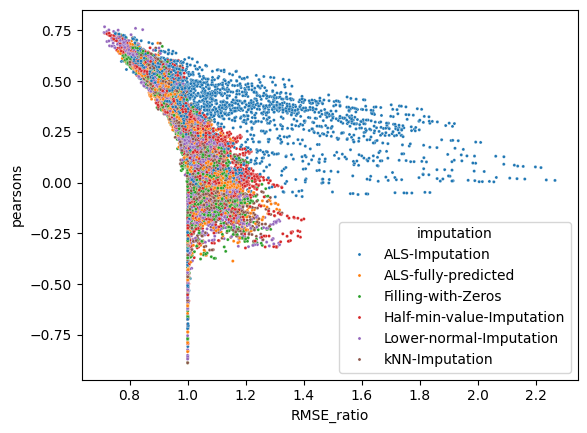

In [7]:
sns.scatterplot(data=df, x='RMSE_ratio', y='pearsons', s=5, hue='imputation')

In [8]:
sorted(set(df['z_score']))

[False, True]

In [9]:
# Pick the one with the best l1_ratio and alpha
crit = 'RMSE_ratio'
crit = 'pearsons'

alphas = sorted(set(df['alpha']))
l1_ratios = sorted(set(df['l1_ratio']))
imps = sorted(set(df['imputation']))
datas = sorted(set(df['dataset']))
zscores = sorted(set(df['z_score']))


frames = []
for imp in imps:
    for data in datas:
        for zscore in zscores:
            dfs = df[(df['imputation']==imp)&(df['dataset']==data)&(df['z_score']==zscore)].copy()
            drugs = sorted(set(dfs['PubChem_CID']))
            for d in drugs:
                dfss = dfs[dfs['PubChem_CID']==d]
                if crit=='RMSE_ratio':
                    frames.append(dfss.sort_values(crit).iloc[:1])
                else:
                    frames.append(dfss.sort_values(crit).iloc[-1:])
dfm = pd.concat(frames, ignore_index=True)
dfm.sort_values('pearsons')

,PubChem_CID,alpha,l1_ratio,imputation,z_score,dataset,pearsons,spearmans,l1_ratios,RMSE,RMSE_mean_model,ind,n_ccls,drug_repr,RMSE_ratio
329,11712625,0.01,0.50,Half-min-value-Imputation,False,Gygi,-0.237934,-0.238279,1.381737,0.137991,0.099983,49.5,35.0,TG-100572,1.380145
505,25167777,0.10,0.90,Lower-normal-Imputation,True,Gygi,-0.108244,-0.063364,1.005641,0.122446,0.122053,49.5,34.0,Omipalisib,1.003225
399,25167777,0.01,0.01,Half-min-value-Imputation,True,Gygi,-0.064203,-0.081965,1.098137,0.130980,0.122053,49.5,34.0,Omipalisib,1.073142
335,135611162,0.03,0.99,Half-min-value-Imputation,False,Gygi,-0.056858,-0.100520,1.162691,0.072918,0.064066,49.5,35.0,dovitinib,1.138173
407,46843057,0.03,0.01,Half-min-value-Imputation,True,Gygi,-0.047652,-0.056437,1.033773,0.126389,0.119879,49.5,34.0,GSK-2110183,1.054307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,11476171,0.03,0.01,kNN-Imputation,True,Gygi,0.731785,0.698622,0.744188,0.063232,0.083592,49.5,35.0,NVP-AEW541,0.756433
396,23635314,0.01,0.01,Half-min-value-Imputation,True,Gygi,0.735919,0.640209,0.708254,0.086804,0.121552,49.5,33.0,KX2-391,0.714137
405,44187362,0.01,0.10,Half-min-value-Imputation,True,Gygi,0.736142,0.628528,0.694416,0.122836,0.169056,49.5,35.0,Pimasertib,0.726600
39,49792852,0.30,0.03,ALS-Imputation,False,Gygi,0.736475,0.699152,0.728766,0.089555,0.119162,49.5,34.0,NMS-1286937,0.751540


In [10]:
df['imputation'].value_counts()

imputation
Half-min-value-Imputation    3408
Lower-normal-Imputation      3325
Filling-with-Zeros           3296
ALS-fully-predicted          3292
kNN-Imputation               3289
ALS-Imputation               3129
Name: count, dtype: int64

In [11]:
dfm['imputation'].value_counts()

imputation
ALS-Imputation               106
ALS-fully-predicted          106
Filling-with-Zeros           106
Half-min-value-Imputation    106
Lower-normal-Imputation      106
kNN-Imputation               106
Name: count, dtype: int64

In [12]:
sorted(set(dfm['imputation']))

['ALS-Imputation',
 'ALS-fully-predicted',
 'Filling-with-Zeros',
 'Half-min-value-Imputation',
 'Lower-normal-Imputation',
 'kNN-Imputation']

In [13]:
desired_order = ['ALS-fully-predicted', 'ALS-Imputation', 'Lower-normal-Imputation', 'kNN-Imputation',
                 'Half-min-value-Imputation', 'Filling-with-Zeros']
dfm['imputation'] = pd.Categorical(dfm['imputation'], categories=desired_order, ordered=True)
plt.rcParams['figure.dpi'] = 300

In [14]:
dfm0 = dfm[dfm['z_score']].copy()
dfm1 = dfm[dfm['z_score']==False].copy()

dfm0s = [a[1] for a in list(dfm0.groupby('dataset'))]
dfm1s = [a[1] for a in list(dfm1.groupby('dataset'))]

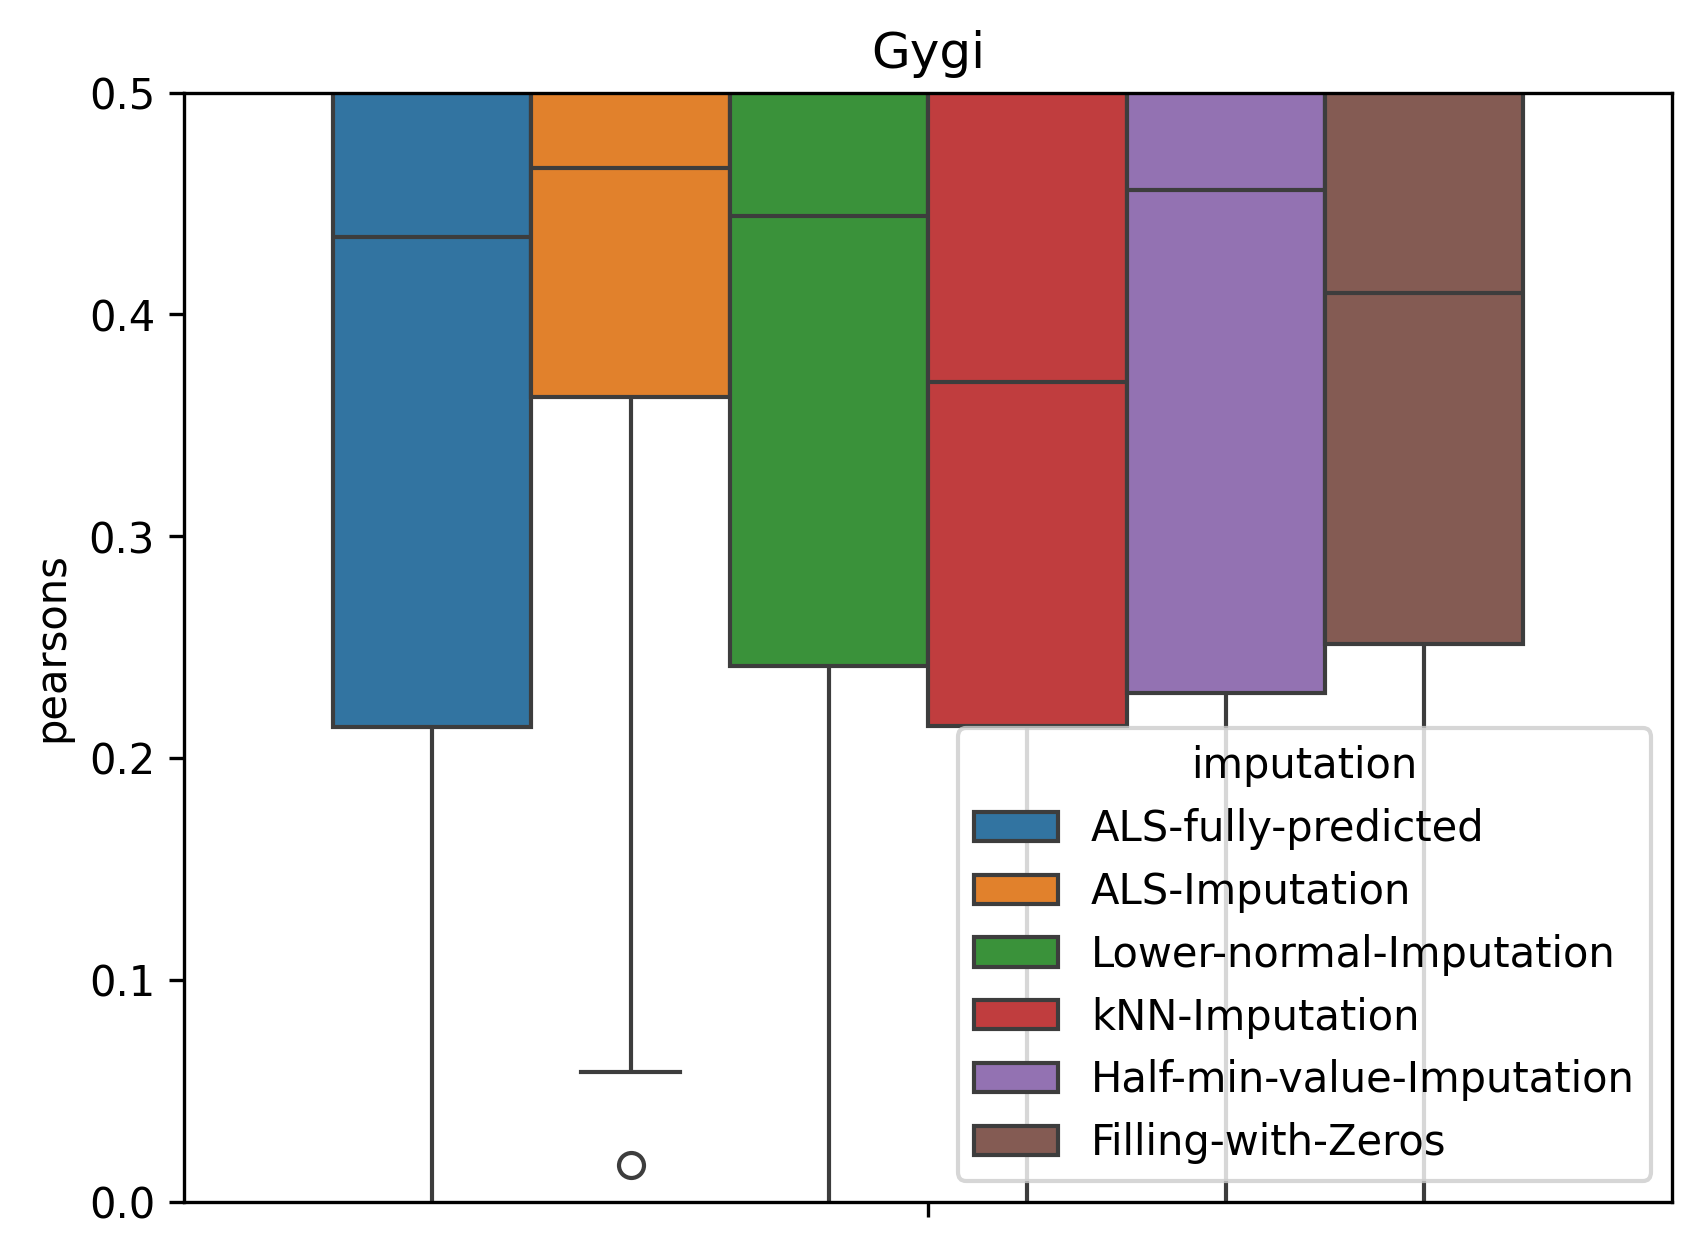

In [15]:
for dfs in dfm0s:
    sns.boxplot(data=dfs, y='pearsons', hue='imputation')
    plt.title(dfs['dataset'].iloc[0])
    plt.ylim(0,0.5)
    plt.pause(0.01)

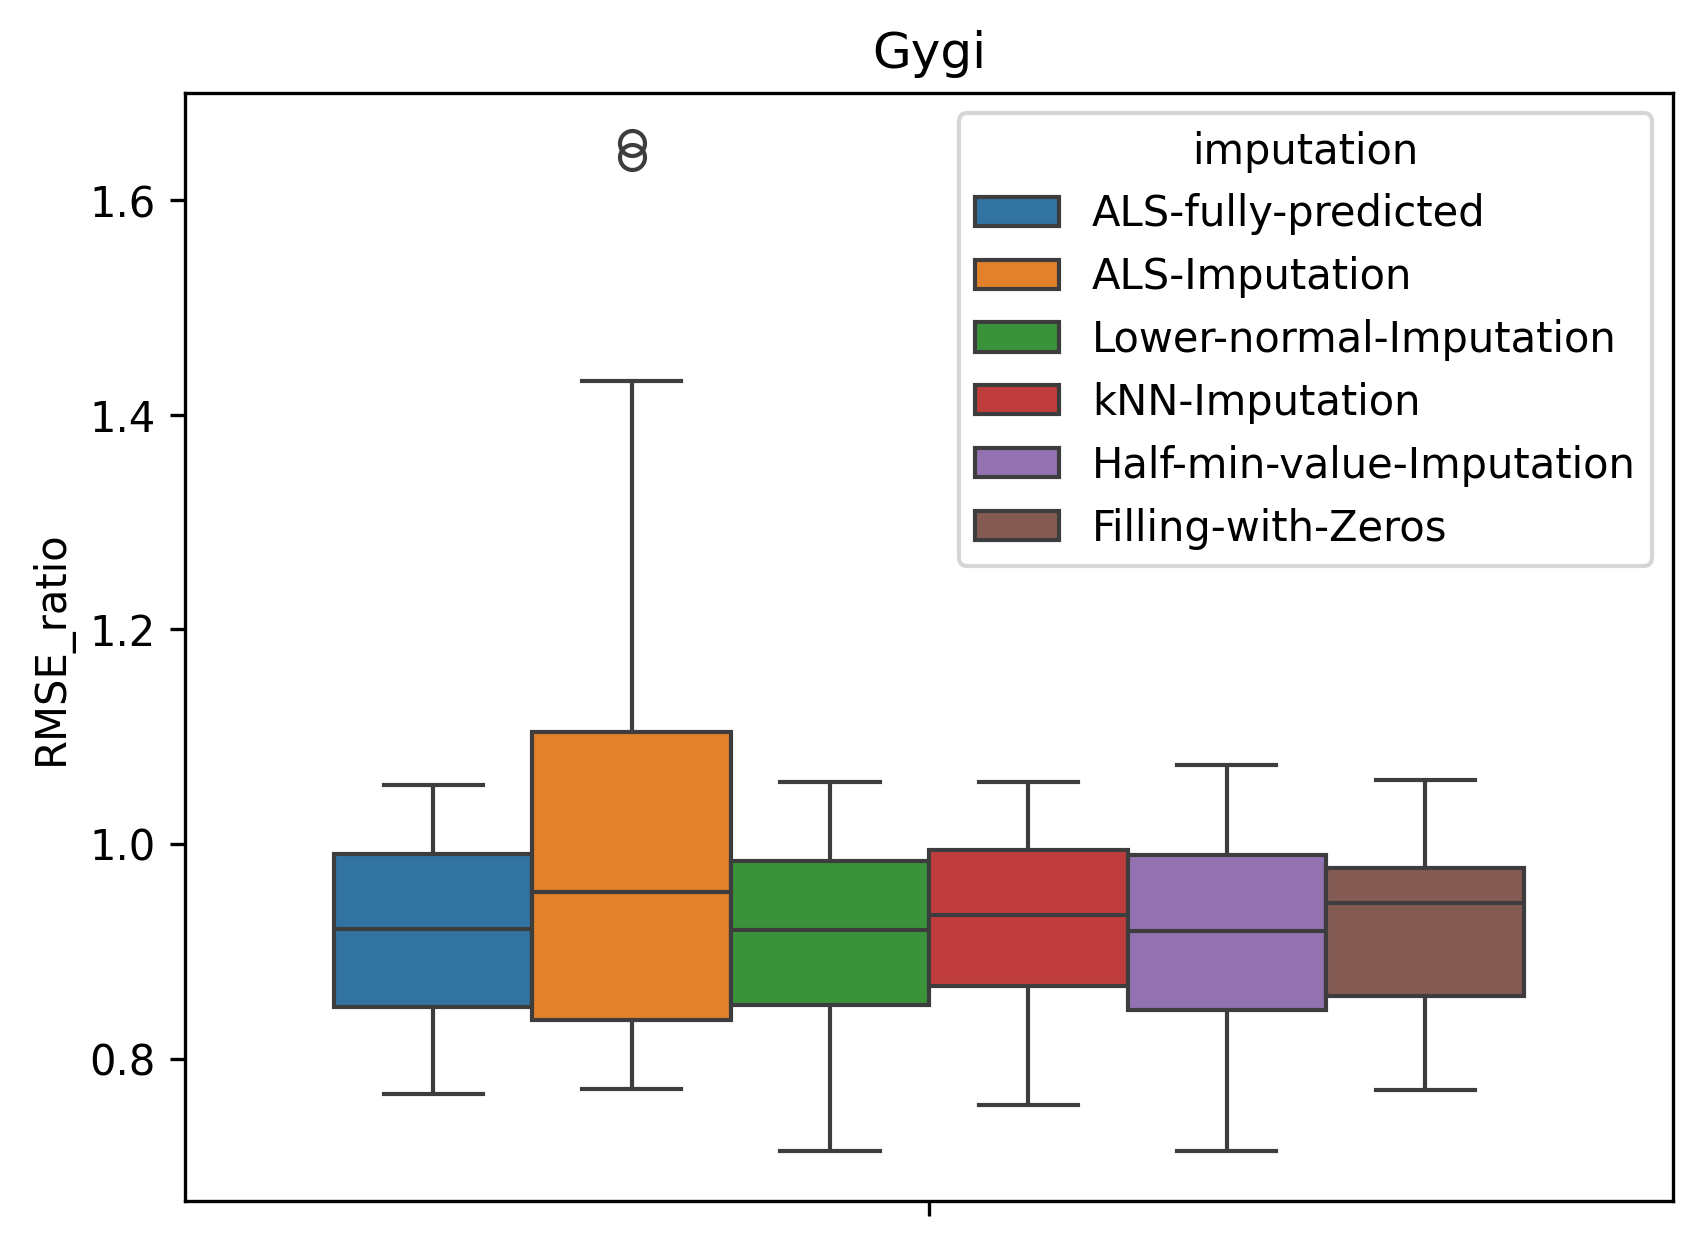

In [16]:
for dfs in dfm0s:
    sns.boxplot(data=dfs, y='RMSE_ratio', hue='imputation')
    plt.title(dfs['dataset'].iloc[0])
    plt.pause(0.01)

Text(0.5, 1.0, 'Gygi-CCLE (Full Proteome)')

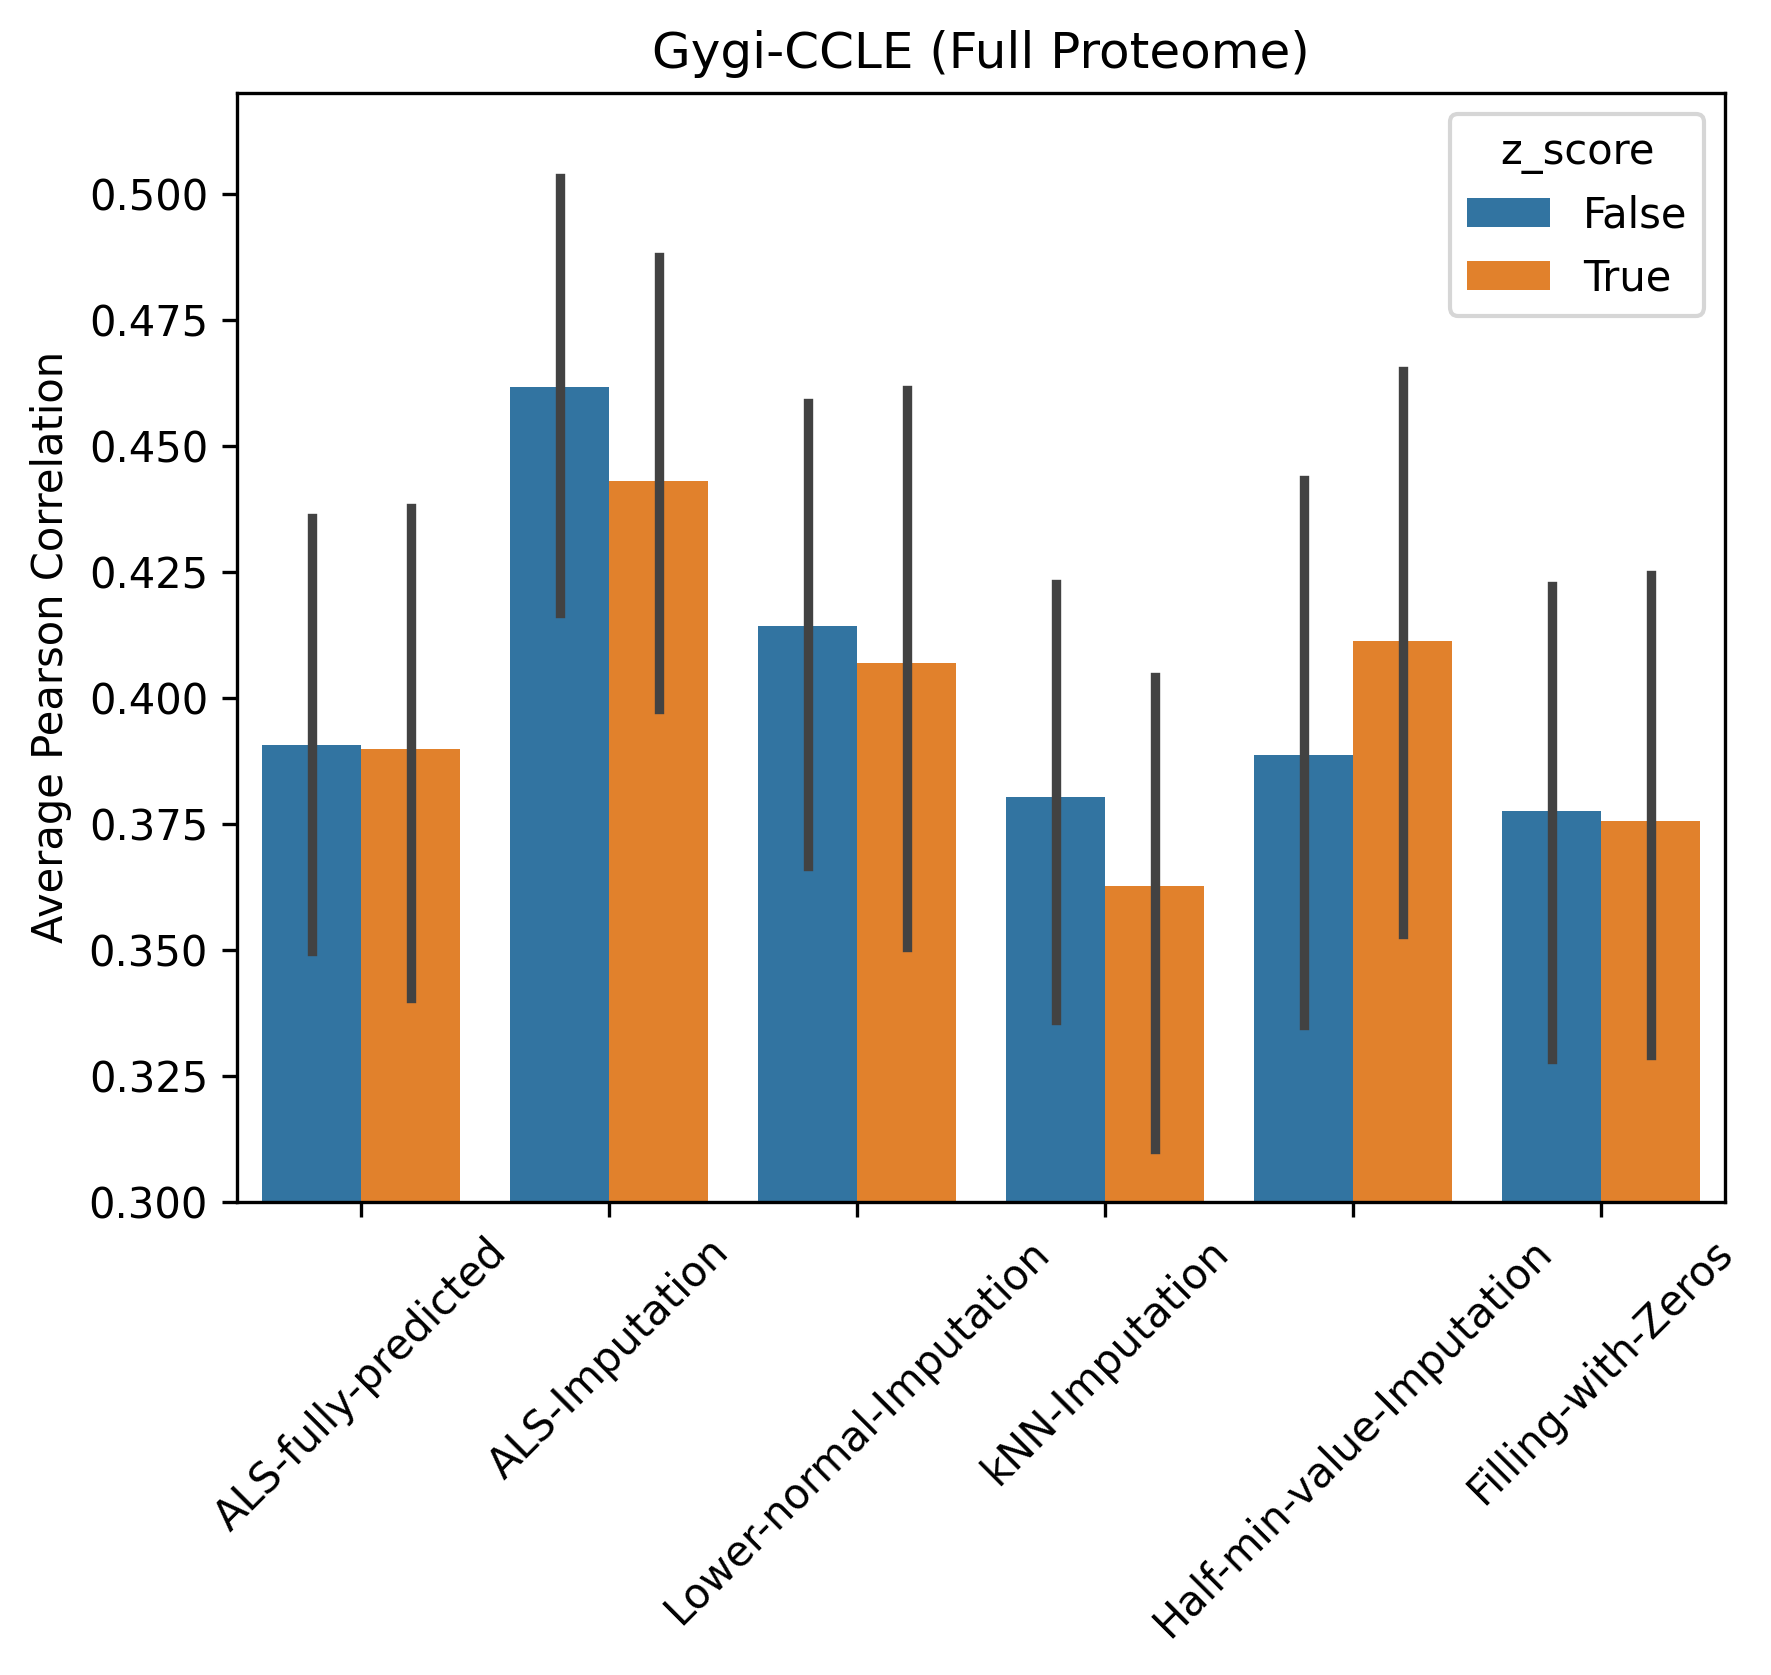

In [17]:
sns.barplot(data=dfm, y='pearsons', x='imputation', hue='z_score')
plt.ylim(0.3, 0.52)
plt.ylabel('Average Pearson Correlation')
plt.xlabel('')
plt.xticks(rotation=45)
plt.title('Gygi-CCLE (Full Proteome)')

Text(0.5, 1.0, 'Gygi-CCLE (Full Proteome)')

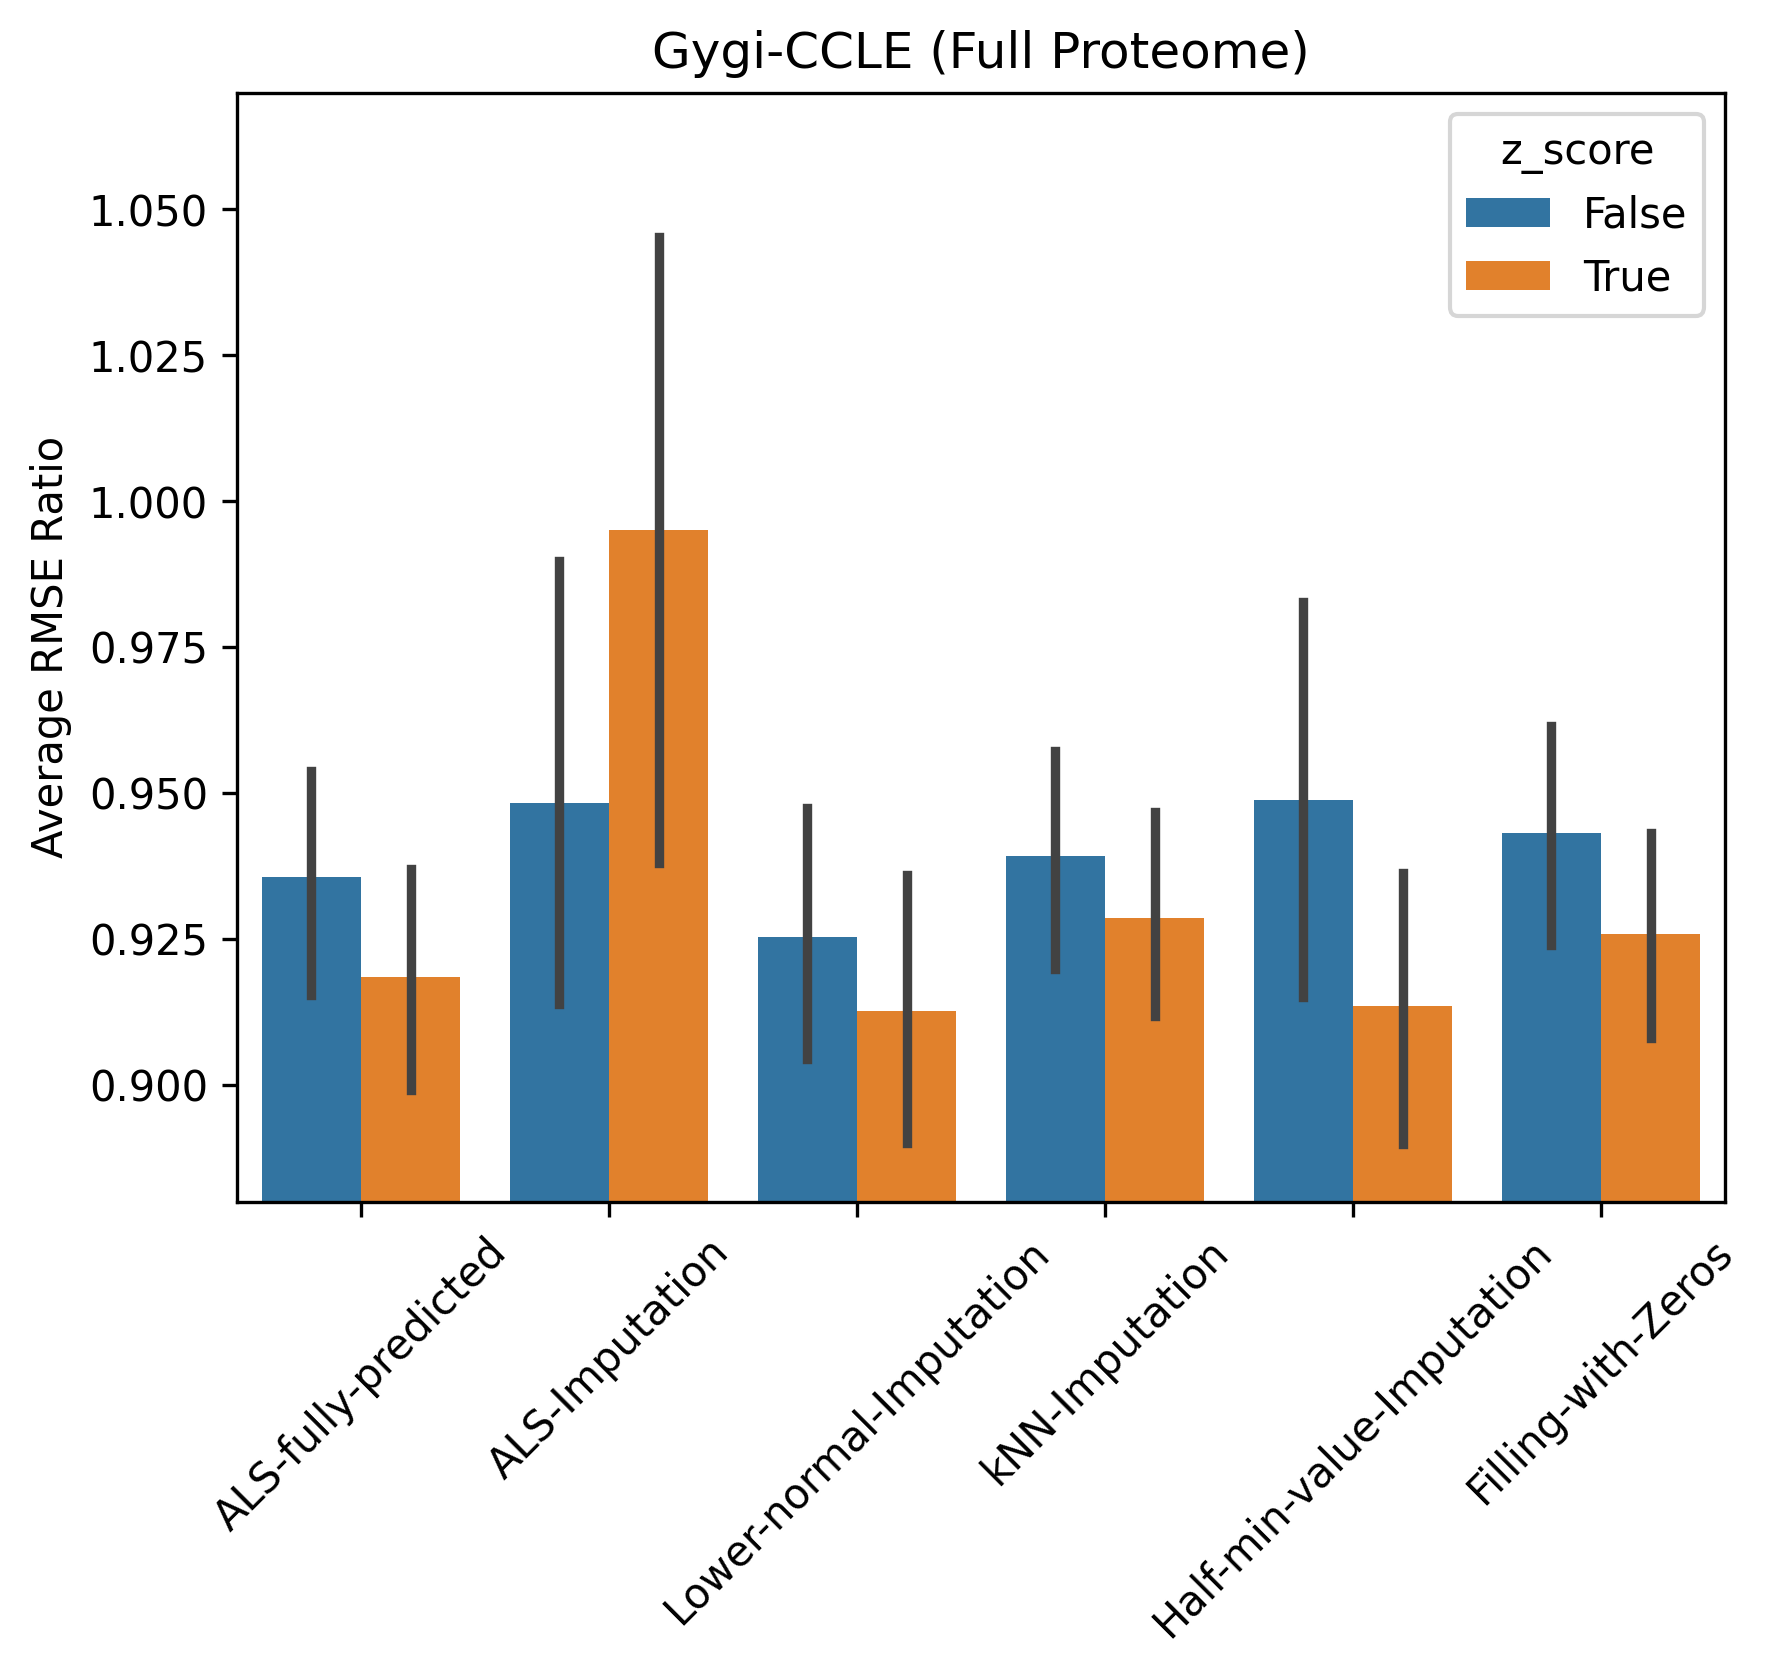

In [22]:
sns.barplot(data=dfm, y='RMSE_ratio', x='imputation', hue='z_score')
plt.ylim(0.88, 1.07)
plt.ylabel('Average RMSE Ratio')
plt.xlabel('')
plt.xticks(rotation=45)
plt.title('Gygi-CCLE (Full Proteome)')